In [1]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation, RandomContrast, RandomHeight, RandomWidth
from tensorflow import keras
from keras import layers
from keras import models
from tensorflow.keras import optimizers
from sklearn.metrics import classification_report
import numpy as np

2025-06-12 12:47:45.838013: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749728865.851358  212246 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749728865.855319  212246 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749728865.864999  212246 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749728865.865014  212246 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749728865.865015  212246 computation_placer.cc:177] computation placer alr

In [2]:
tf.__version__

'2.19.0'

# MODELO S

## 1 - Data Preprocessing

Caminhos dos sets

In [3]:
train_dir = 'dataset_balanceado_final/train'
validation_dir = 'dataset_balanceado_final/validation'
test_dir = 'dataset_balanceado_final/test'

Definir batch_size e image_size

In [4]:
from tensorflow.keras.utils import image_dataset_from_directory

IMG_SIZE = 150
BATCH_SIZE = 32

Training set -  É o conjunto de dados usado para treinar a rede

In [5]:
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical' # categorical porque temos várias classes, senão seria binário (2 classes)
)

Found 4276 files belonging to 7 classes.


I0000 00:00:1749728868.197692  212246 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 757 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:03:00.0, compute capability: 7.5
I0000 00:00:1749728868.201230  212246 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 4738 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:05:00.0, compute capability: 7.5


Validation set - Usado para 'testar' o modelo durante o processo de procura da melhor combinação de hiperparâmetros.

In [6]:
validation_dataset = image_dataset_from_directory(
    validation_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

Found 1420 files belonging to 7 classes.


Test set - Usado para testar o modelo depois do processo de treino

In [7]:
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

Found 1420 files belonging to 7 classes.


#### Data Augmentation 

Gerar mais dados de treino a partir de amostras de treino existentes, aumentando as amostras através de uma série de transformações aleatórias que produzem imagens com aspeto credível.

In [8]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),          # Espelo horizontal
    layers.RandomRotation(0.4),               # Rotação até 10%
    layers.RandomTranslation(0.1, 0.2),        # "Deslocamento" na largura (10%) e altura (20%)
    layers.RandomFlip("vertical"),            # Espelho vertical
])

### Métricas para avaliar os modelos

In [9]:
# Utiliza uma função(do sckicit-learn) para avaliar o desempenho do modelo, indicando Métricas como: 
    # f1-score do modelo
    # accuracy do modelo
    # accuracy por classe 

from sklearn.metrics import classification_report
import numpy as np

def print_classification_metrics(model, dataset, phase_name):
    y_true = []
    y_pred = []

    for images, labels in dataset:
        preds = model.predict(images)
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        y_pred.extend(np.argmax(preds, axis=1))

    print(f"\n {phase_name}")
    print(classification_report(y_true, y_pred, digits=4))


## 2 - Construir a CNN (convolucional Neural Network) 

In [10]:
# Define a camada de entrada do modelo com o formato das imagens (altura, largura, 3 canais RGB).
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)) 

In [11]:
#Aplica as transformações aleatórias às imagens (definidas no inicio do notebook) para aumentar a diversidade do dataset de treino e evitar overfitting.
x = data_augmentation(inputs) 

In [12]:
# Normaliza os valores dos pixels das imagens de entrada para o intervalo [0, 1].
x = layers.Rescaling(1./255)(x) 

### Passo 1 : Camada Convolucional

In [13]:
# Primeira camada convolucional com 64 filtros 3x3 e ativação ReLU
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x) 
# adicionado o padding="same" para garantir que o output da camada convolucional tem a mesma dimensão espacial (altura e largura) que o input, após a operação de convolução.

### Passo 2 : Camada de Pooling

In [14]:
# Primeira camada de pooling máximo (2x2) para reduzir a dimensionalidade.
x = layers.MaxPooling2D(pool_size=2)(x)

### Passo 3 : Adicionar mais camadas 

In [15]:
# Segunda camada convolucional com 128 filtros 3x3 e ativação ReLU.
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
# Segunda camada de pooling máximo (2x2).
x = layers.MaxPooling2D(pool_size=2)(x)

In [16]:
# Terceira camada convolucional com 128 filtros 3x3 e ativação ReLU.
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
# Terceira camada de pooling máximo (2x2).
x = layers.MaxPooling2D(pool_size=2)(x)

### Passo 4 : Flattening 

In [17]:
# Achata o output das camadas convolucionais para um vetor 1D.
x = layers.Flatten()(x)

BATCH NORMALIZATION  (Facultativo)

In [18]:
# tirar comentario desta linha abaixo se queremos usar batch normalization
# porem foi testado varias vezes e em diferentes camadas da rede, mas não melhorou o desempenho do modelo (e o optuna tambem sugeriu nao utilizar)
#x = layers.BatchNormalization( axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,beta_initializer="zeros",    moving_mean_initializer="zeros", moving_variance_initializer="ones")(x)

#### Dropout (facultativo) - funçao de regularização

In [19]:
# Aplica Dropout (50%) para desativar aleatoriamente neurónios, prevenindo o overfitting.
#x = layers.Dropout(0.6)(x)

### Passo 5 : Full Connection

In [20]:
# Definir funçao de Regularização L2 (opcional)
#reg = regularizers.l2(0.02)  # Executar para ativar

# Camada densa (totalmente conectada) com 128 neurónios, ativação ReLU e funçao de regularizaçao L2
x = layers.Dense(128, activation="relu")(x) #, kernel_regularizer=reg

### Passo 6 : Output Layer

In [21]:
# Camada de saída densa com 7 neurónios e ativação Softmax (para classificação categórica).
outputs = layers.Dense(7, activation="softmax")(x) 

In [22]:
# Cria o modelo Keras usando as camadas de entrada e saída definidas.
model = keras.Model(inputs=inputs, outputs=outputs)

## 3 - Treinar a rede CNN 

#### Funções de otimização disponíveis: Adam, RMSprop e SGD

#### Funções de loss disponíveis: categorical_crossentropy    ,    KLDivergence e MSE 

In [23]:
# Configura o otimizador RMSprop
# Define a função de loss: Categorical Crossentropy
# Indica que a 'accuracy' (precisão) será a métrica durante o treino.
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])

In [24]:
#model.compile(
    #optimizer='SGD', 
    #loss='mse',
    #metrics=['accuracy'])

In [25]:
#model.compile(
    #optimizer=tf.keras.optimizers.RMSprop(),
    #loss=tf.keras.losses.KLDivergence(),
    #metrics=['accuracy'])

### Treinar o modelo

In [26]:
history = model.fit(
    train_dataset, #Inicia o treino do modelo usando o conjunto de dados de treino.
    epochs=25,     # O modelo será treinado por 30 épocas (passagens completas pelo conjunto de treino).
    validation_data=validation_dataset) # Usa o conjunto de dados de validação para monitorizar o desempenho do modelo em dados não vistos durante o treino.

Epoch 1/25


I0000 00:00:1749728871.642469  212316 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-12 12:47:51.795902: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 441.19MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-12 12:47:51.808742: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-12 12:47:51.821966: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 321.72MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains 

134/134 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - accuracy: 0.1578 - loss: 2.6429 - val_accuracy: 0.2275 - val_loss: 1.8800
Epoch 2/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.2896 - loss: 1.7794 - val_accuracy: 0.4099 - val_loss: 1.5432
Epoch 3/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.3918 - loss: 1.5592 - val_accuracy: 0.4838 - val_loss: 1.3287
Epoch 4/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.4351 - loss: 1.4494 - val_accuracy: 0.4401 - val_loss: 1.4237
Epoch 5/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.4586 - loss: 1.3746 - val_accuracy: 0.5092 - val_loss: 1.2822
Epoch 6/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.4872 - loss: 1.3219 - val_accuracy: 0.4937 - val_loss: 1.3056
Epoch 7/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.4865 - loss: 1.2905 - val_accuracy: 0.5514 - val_loss: 1.2897
Epoch 8/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.5232 - loss: 1.2461 - val_accurac

## 4 - Testar o modelo

In [27]:
print_classification_metrics(model, test_dataset, "Modelo 1 : CNN de raiz")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━

2025-06-12 12:52:11.172953: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Ver as Curvas de Loss e de Accuracy

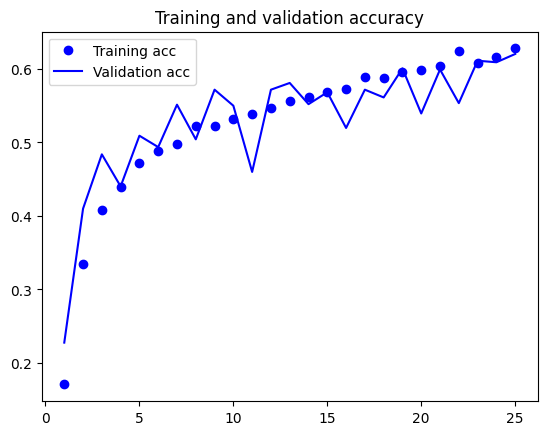

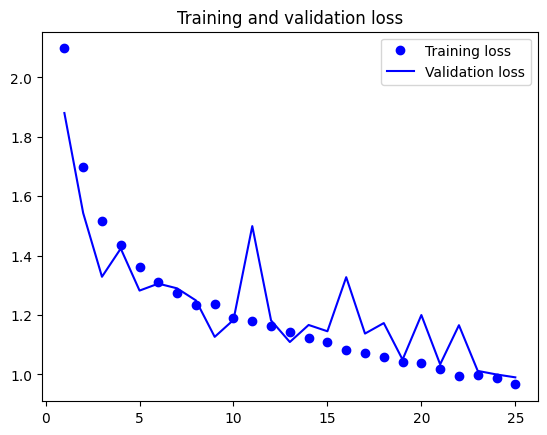

In [28]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

As curvas mostram que o modelo foi bem treinado, com melhoria consistente na acurácia e diminuição contínua da loss. Não há sinais de overfitting. A generalização é boa e o desempenho pode possivelmente ser melhorado com mais épocas ou ajustes finos.

### Matriz de Confusão

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━

2025-06-12 12:52:15.072421: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<Figure size 1000x800 with 0 Axes>

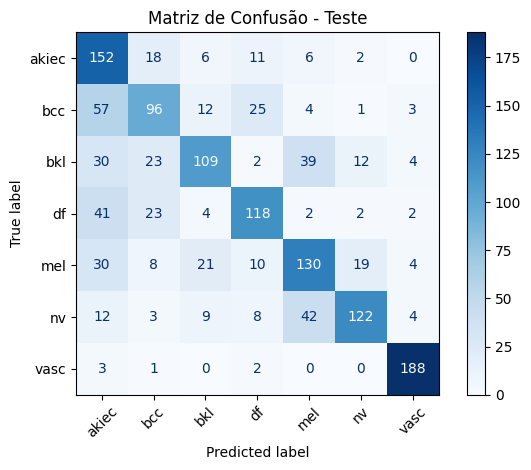

In [29]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Obter predições no test_dataset
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

class_names = test_dataset.class_names  

# Criar e mostrar a matriz de confusão
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45, values_format='d')
plt.title("Matriz de Confusão - Teste")
plt.tight_layout()
plt.show()

## Salvar o modelo 

In [30]:
model.save("modelS_2B2_com_data_aug_RMS_cat_cross_best_acc.keras")